<a href="https://colab.research.google.com/github/AloyKyllian/NOTE/blob/main/tp1_neuralnetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 1: Réseaux de neurones (1)

## 0. Introduction and préliminaires

Dans cette session, nous verrons des réseaux simples dense, dits "feed-forward" pour de la classification.
Nous utiliserons le module Tensorflow et sa sous-partie Keras qui donne un accès de haut niveau aux éléments classiques d'une architecture de réseau de neurones.
On retrouvera matplotlib/pylab pour la visualisation.


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
from tensorflow import keras


import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

## 1. Classifying handwritten digits (classification de chiffres manuscrits)

Nous allons étudier le célèbre jeu de données MNIST, d'image de chiffres écrits à la main.
Il contient 70000 instances de chiffres (0-9), dont 60000 réservés pour l'entrainement et 10000 pour le test.

### Charger MNIST
keras fournit une fonction spécialement dédiée:

In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


Les données sont chargées dans des matrices numpy

* `train_images` et `train_labels` contient les données d'entrainement
* `test_images` et `test_labels` contient les données de test, pour évaluer les performances du modèel

Les images sont des matrices de 28x28 pixels avec une valeur entre 0 et 255.

Les labels sont les entiers représentant les chiffres correspondant à chaque image.


### Exploration des données
Regardons un peu ce qu'il y a dans les données :

In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
test_images.shape

(10000, 28, 28)

`train_images` est en fait un *tenseur*, un array numpy avec 3 axes, les 60000 instances de 28x28 valeurs, comme avoir un vecteur de matrices 28x28  


Par exemple, une image serait :

In [ ]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

On voit que chaque pixel a une valeur entre 0 et 255.

Pour chaque image, le vrai label est stocké avec le même indice dans `train_labels`

In [ ]:
len(train_labels)

60000

Quel est le label de la première image ?

In [ ]:
print(train_labels[0])

5


### Prétraitements

Le code ci-dessous visualise la première image:

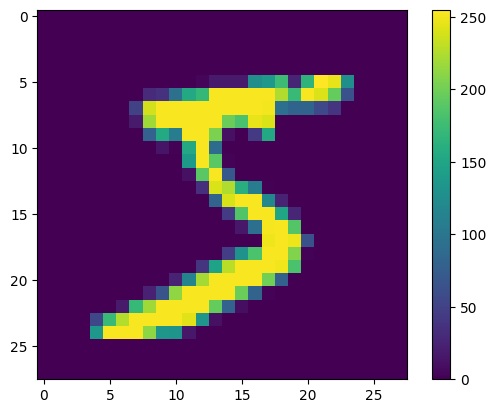

In [ ]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Il est généralement préférable de normaliser les scores entre [0,1]

On peut juste ici se contenter de diviser par le max théorique (255)


In [ ]:
train_images = train_images / 255.0

test_images = test_images / 255.0

On peut vérifier ce que ça donne sur quelques images

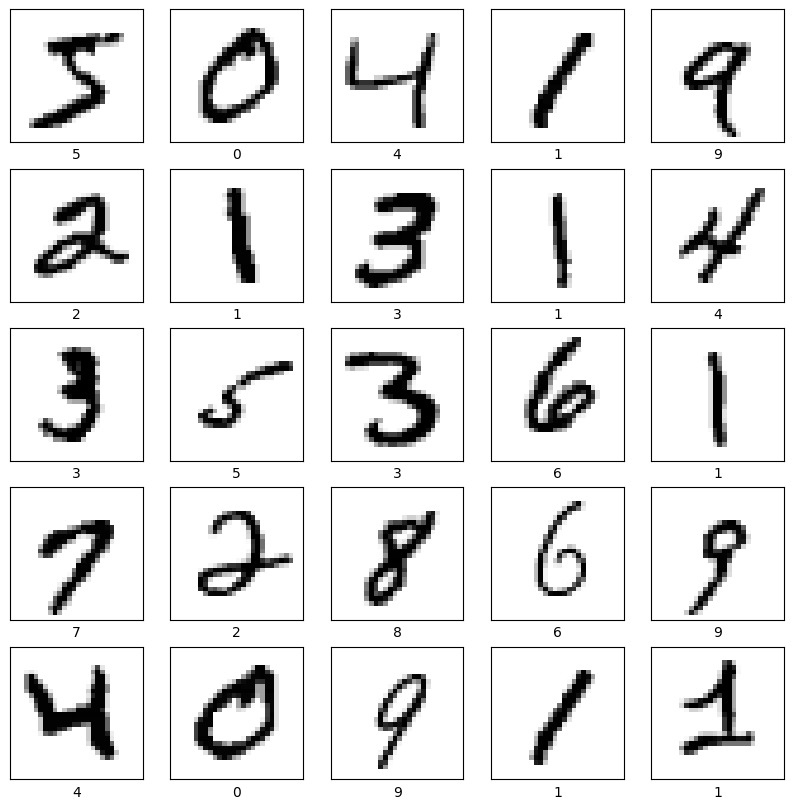

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

### Définir le modèle

Définir un modèle comporte plusieurs étapes.

La première est d'articuler les couches qui constituent l'architecture.

Keras fournit une construction de séquence avec la classe `Sequential`, qui permet de combiner les éléments: couches, fonctions d'activation ... en "cachant" les paramètres qui seront appris.

Par exemple:

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(80, activation='relu'),
    keras.layers.Dense(80, activation='elu'),
    # keras.layers.Dropout(0.33),
    keras.layers.Dense(10, activation='softmax')
])

L'étape de traitement Flatten transforme la matrice 28x28 en un seul vecteur de (28 * 28 = 784) valeurs.

Ensuite on ajoute des couches complètement connectées ("Dense"), qui relie l'entrée, 768 valeurs pour la première,
et qui sort 2 résultats, qui sert d'entrée à la couche suivante (la dernière), qui sort 10 valeurs.
On ajoute à chaque fois une fonction d'activation sur chaque sortie.

Le softmax ramène les valeurs entre 0 et 1 en sortie, valant 1 au total, comme une distribution de probabilités.

Ensuite on définit un certains nombre de points qui permettent de compléter pour pouvoir entrainer le modèle:  

* **une loss**: la fonction de perte; ici on a un problème de classification donc nous prendrons l'entropie croisée (cross-entropy)
* **un optimiseur**: la procedure pour minimiser la loss, on prendra le plus simple (sgd = stochastic gradient descent).
* **une métrique**: qui sert à évaluer le modèle au final. Ici on veut savoir la proportion d'images correctement classifiées ("accuracy").


In [ ]:
# Stochastic Gradient Descent
sgd = tf.keras.optimizers.Adam()
# Optimizer.apply_gradients(grads_and_vars)
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'], )

### Entrainement

Le modèle est compilé, et est prêt à être entrainé, en lui fournissant les données d'entrainement, avec la réponse attendue.

La méthode pour entrainer le modèle s'appelle `fit`.
Le modèle va voir chaque exemple plusieurs fois, à définir. On appelle "epoch" le fait d'avoir vu tous les exemples une fois.
On spécifie donc le nombre d'epochs, ici 10, donc chaque exemple sera vu 10 fois.  

Un dernier paramètre est de dire combien d'exemples seront mis de côté pour surveiller les performances du modèle
au cours de l'entrainement (un jeu de validation, ou `validation split`).

Ici
`validation_split=0.1` dit à Keras de garder 10% du jeu de données pour validation.

Cela permet de surveiller par exemple l'overfitting.

In [ ]:
# Fonction pour l'affichage de l'historique des métriques d'apprentissage
def plot_history(history, val=False):
    plt.plot(history.history['accuracy'])
    if val:
        plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    if val:
        plt.legend(['train', 'val'], loc='upper left')
    else:
        plt.legend(['train'], loc='upper left')
    plt.show()

In [ ]:
h = model.fit(train_images, train_labels, epochs=20, validation_split=0.1)

Epoch 1/20
1688/1688 [==============================] - 4s 2ms/step - loss: 0.2664 - accuracy: 0.9216 - val_loss: 0.1202 - val_accuracy: 0.9638
Epoch 2/20
1688/1688 [==============================] - 3s 2ms/step - loss: 0.1180 - accuracy: 0.9648 - val_loss: 0.0921 - val_accuracy: 0.9745
Epoch 3/20
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0816 - accuracy: 0.9751 - val_loss: 0.0837 - val_accuracy: 0.9752
Epoch 4/20
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0630 - accuracy: 0.9802 - val_loss: 0.0841 - val_accuracy: 0.9753
Epoch 5/20
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0498 - accuracy: 0.9844 - val_loss: 0.0857 - val_accuracy: 0.9785
Epoch 6/20
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0406 - accuracy: 0.9867 - val_loss: 0.0850 - val_accuracy: 0.9790
Epoch 7/20
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0358 - accuracy: 0.9881 - val_loss: 0.0979 - val_accuracy:

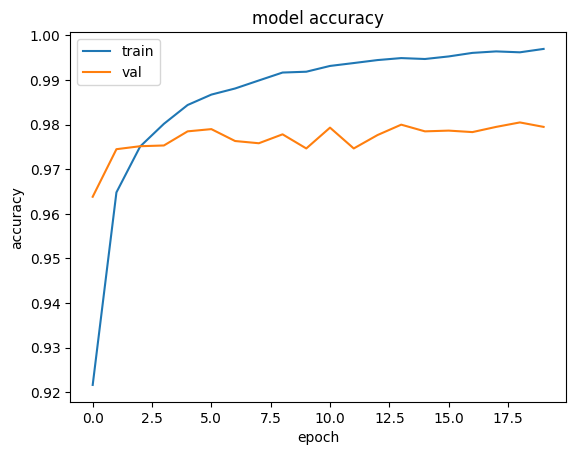

In [ ]:
plot_history(h, val=True)

### Evaluation du modèle

Ensuite on vérifie la "vraie" performance une fois que l'entrainement est finie, sur les données de test.

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.1190 - accuracy: 0.9792 - 333ms/epoch - 1ms/step

Test accuracy: 0.979200005531311


### Faire des prédictions

On peut aussi utiliser le modèle pour faire des prédictions sur des images, ici voyons le résultat sur toutes les instances de test:

In [ ]:
predictions = model.predict(test_images)

313/313 [==============================] - 0s 1ms/step


Si on regarde les prédictions pour la première image du test :

In [ ]:
predictions[0]

array([2.3656874e-15, 3.3534702e-14, 9.9241192e-14, 3.1420519e-12,
       3.0617765e-23, 4.4374150e-19, 1.2757391e-24, 9.9999994e-01,
       5.4563679e-18, 1.2412014e-11], dtype=float32)

On voit la probabilité de chaque classe (donc d'être un numéro particulier). Pour trouver le meilleur on peut faire:

In [ ]:
np.argmax(predictions[0])

7

On peut vérifier que la réponse correspond au label attendu pour cet exemple :

In [ ]:
test_labels[0]

7

Voici une fonction pour afficher plus clairement le vecteur de probabilités :

In [ ]:
def plot_image(i, predictions_array, true_label, img, class_names=None):
    if class_names == None:
        class_names = range(len(predictions_array))
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


On peut regarder sur la première image. En bleu la décision du modèle en rouge la bonne réponse.

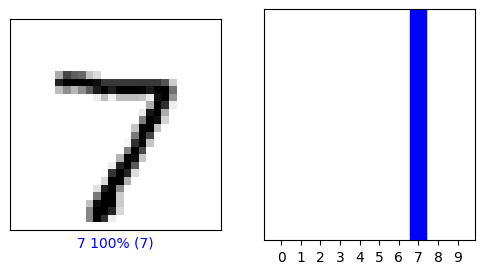

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()


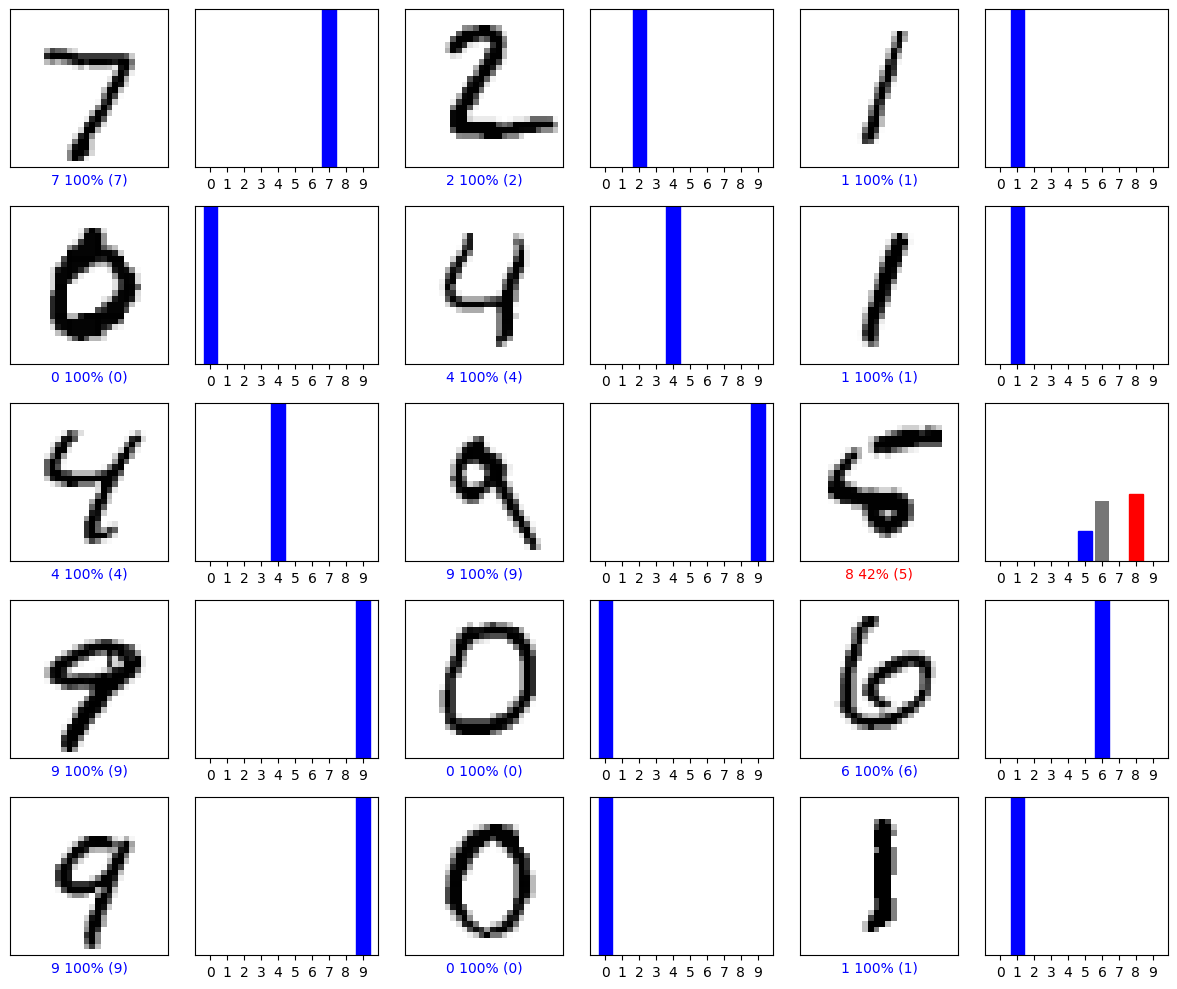

In [ ]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()


La même chose pour 15 images. Pouvez vous voir si les erreurs sont cohérentes ? Si vous voyez pourquoi


### Exercices
* **Exercice 1**: Le modèle défini plus haut n'a qu'une couche cachée avec seulement deux neurones. Quelles sont les accuracies que vous obtenez sur le jeu d'entrainement ? sur le test ? Essayez d'augmenter le nombre de neurones pour voir l'influence de ce facteur. 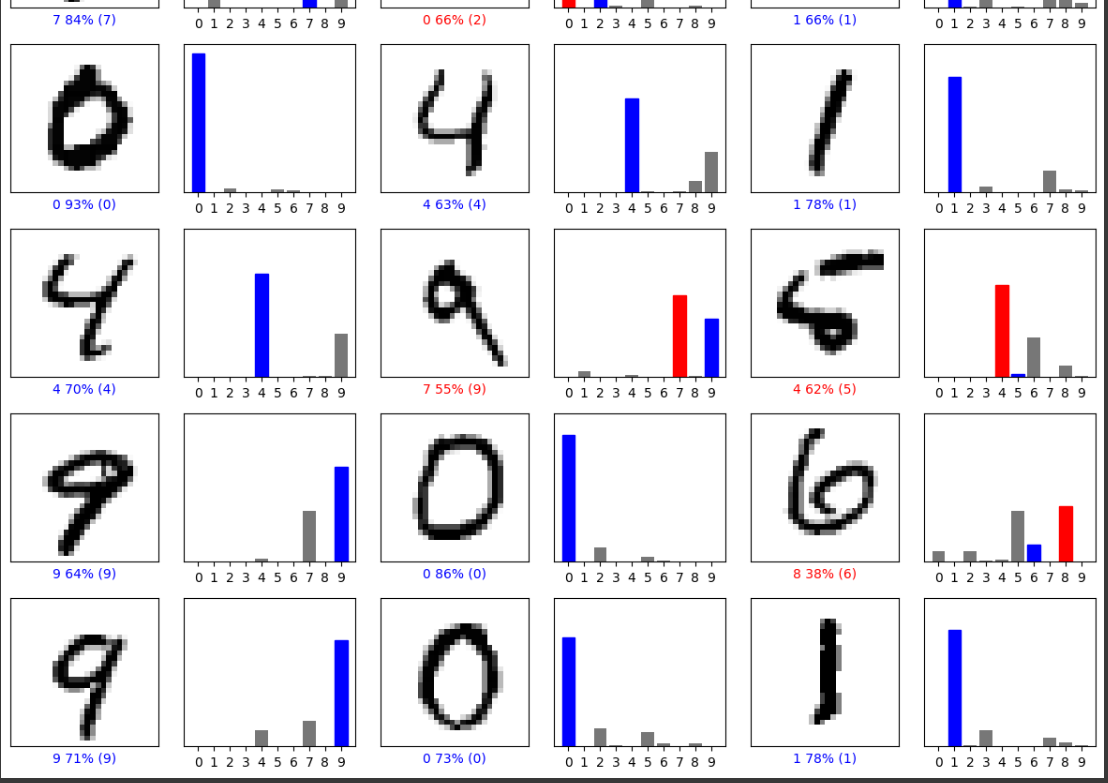

* **Exercice 2**: Il y a beaucoup de choix possibles pour la fonction d'activation. Regardez la documentation Keras (https://keras.io/api/layers/activations/) pour en essayer d'autres. Quelle est celle qui semble le mieux fonctionner ici ?

j'ai essayer relu avec 100 neurones
            relu6 avec 40 neurones
            selu avec 50 neurones

tout est bien mais relu est moins bien


* **Exercice 3**: On a vu en cours l'intérêt de régulariser le modèle, par exemple avec un "drop out", qui met au hasard à 0 un certain nombres de valeur pour éviter de trop spécialiser le modèle sur certains neurones.  Ajouter un drop out (https://keras.io/api/layers/regularization_layers/dropout/) à la première couche en donnant une probabilité de 0.5 (la moitié des neurones sont mis à 0 après un passage).

ca reduit fortement 0.5 c'est tres haut il faut rajouter des epachs

* **Exercice 4**: Faites varier la procédure d'optimisation de la loss, en testant certaines possibilités de Keras (https://keras.io/api/optimizers/#available-optimizers). Qu'est-ce qui marche le mieux ?

adam marche tres bien

* **Exercise 5**: Essayez de changer le modèle en ajoutant une ou plusieurs couches.


* **Exercise 6; bonus**: Dessinez votre propre chiffre, et utilisez votre modèle pour faire une prédiction. Il faut que l'image soit de la taille 28x28. Vous pouvez utiliser par exemeple https://www.pixilart.com/draw.
Pour charger l'image utilisez la fonction `plt.imread`. L'image produite eest en RGBA, et donc l'array retourné de dimensions (28,28,4) matrix. Vous pouvez juste prendre le canal rouge avec les indices `[:,:,0]` et ensuite faire `image = np.expand_dims(image, axis=0)` pour passer l'image (28,28) en (1,28,28) qui est ce qu'attend la fonction `model.predict` (un vecteur d'image 28x28, ici de taille 1).

In [ ]:
## Exercise 6:
## à vous de jouer

## 2. Reconnaissance d’objets

### Les données CIFAR10

Le jeu de données cifar10 contient 60000 instances d'images représentant 10 classes d'objets, avec leur label. Keras permet de le charger directement :

In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


Les labels sont codés un peu différemment. Pour avoir un seul vecteur de labels, on va d'abord aplatir les vecteurs donnés.

In [ ]:
train_labels = train_labels.flatten()
test_labels = test_labels.flatten()

print(train_images[0])

train_images = train_images / 255.0
test_images = test_images / 255.0
print(train_images[0])

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
[[[0.23137255 0.24313725 0.24705882]
  [0.16862745 0.18039216 0.17647059]
  [0.19607843 0.18823529 0.16862745]
  ...
  [0.61960784 0.51764706 0.42352941]
  [0.59607843 0.49019608 0.4       ]
  [0.58039216 0.48627451 0.40392157]]

 [[0.0627451  0.07843137 0.07843137]
  [0.         0.         0.        ]
  [0.07058824 0.03137255 0.        ]
  ...
  [0.48235294 0.3450980

In [ ]:
train_images[0].shape
print(train_images.shape)
test_images.shape

(50000, 32, 32, 3)


(10000, 32, 32, 3)

Chaque classe est représentée par un nombre, on va donc leur associer un nom.

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Voilà comment afficher les premières images de la base:

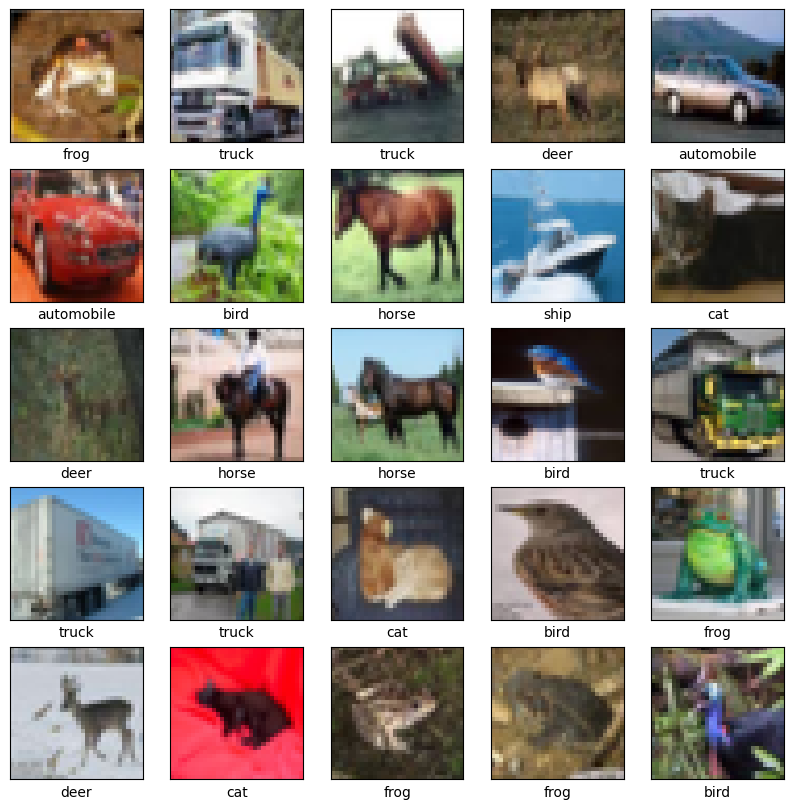

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### Exercices

* **Exercice 7**: Définissez une architecture de reconnaissance d'objets pour CIFAR en vous inspirant de ce que vous avez fait pour MNIST, toujours `Sequential`. Compilez le modèle avec une loss, un optimiseur et une métrique. Faites variez les paramètres pour obtenir le meilleur résultat que vous pouvez. Vous pouvez encore utiliser `plot_image` et `plot_value_array` définies plus haut pour explorer les prédictions du modèle sur une seule image.

In [ ]:
from tensorflow.keras.utils import to_categorical
# Transformer les données en 4D (batch_size, height, width, channels)
train_images = train_images.reshape(-1, 32, 32, 3)
test_images = test_images.reshape(-1, 32, 32, 3)

# Prétraiter les étiquettes
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)


print(train_images.shape)
print(train_labels.shape)

(50000, 32, 32, 3)
(50000, 10)


In [ ]:
## Exercice 7

## à vous ...

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])


# model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(32, 32, 3)),
#     # keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
#     # keras.layers.MaxPooling2D((2, 2)),
#     keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     keras.layers.MaxPooling2D((2, 2)),
#     keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     keras.layers.MaxPooling2D((2, 2)),
#     keras.layers.Flatten(),
#     keras.layers.Dense(128, activation='relu'),
#     # keras.layers.Dense(1024, activation='relu'),
#     # keras.layers.Dropout(0.2),
#     # keras.layers.Dense(512, activation='relu'),
#     # keras.layers.Dropout(0.1),
#     # keras.layers.Dense(128, activation='relu'),
#     # keras.layers.Dropout(0.1),
#     keras.layers.Dense(10, activation='softmax')
# ])

In [ ]:
adam = tf.keras.optimizers.Adam()

model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'], )

In [ ]:
h = model.fit(train_images, train_labels, epochs=20, validation_split=0.1)

Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-54-3005a969e257>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [32,10] and labels shape [320]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_376814]

In [ ]:
plot_history(h, val=True)

NameError: name 'plot_history' is not defined

In [ ]:
predictions = model.predict(test_images)

313/313 [==============================] - 4s 11ms/step


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

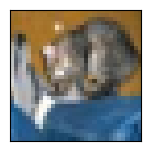

In [ ]:


num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()




# plt.figure(figsize=(10,10))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(train_images[i], cmap=plt.cm.binary)
#     plt.xlabel(class_names[train_labels[i]])
# plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 3s - loss: 1.2588 - accuracy: 0.6785 - 3s/epoch - 11ms/step

Test accuracy: 0.6784999966621399


In [ ]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

# Charger le jeu de données
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()
train_labels = train_labels.flatten()
test_labels = test_labels.flatten()

# Afficher une image avant la normalisation
print("Image avant normalisation :")
print(train_images[0])

# Normaliser les images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Afficher une image après normalisation
print("Image après normalisation :")
print(train_images[0])

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

print(train_images.shape)
print(train_labels.shape)

# Définir le modèle
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle avec validation
h = model.fit(train_images, train_labels, epochs=20, validation_split=0.1)

# Évaluer le modèle sur des données de test (assurez-vous d'avoir des données de test)
# test_loss, test_acc = model.evaluate(test_images, test_labels)
# print(f"Test accuracy: {test_acc}")


Image avant normalisation :
[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
Image après normalisation :
[[[0.23137255 0.24313725 0.24705882]
  [0.16862745 0.18039216 0.17647059]
  [0.19607843 0.18823529 0.16862745]
  ...
  [0.61960784 0.51764706 0.42352941]
  [0.59607843 0.49019608 0.4       ]
  [0.58039216 0.48627451 0.40392157]]

 [[0.0627451  0.07843137 0.07843137]
  [0.         0.         0.        ]
  [0.07058

In [ ]:
import sklearn.neural_network
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Options spécifiques pour le MLPClassifier
options_mlp = {
    'hidden_layer_sizes': (100,),  # Nombre de neurones dans chaque couche cachée
    'activation': 'relu',  # Fonction d'activation ('relu' est couramment utilisé)
    'solver': 'adam',  # Optimiseur pour la descente du gradient
    'max_iter': 1000,  # Nombre maximal d'itérations
}

# Création de l'objet MLPClassifier avec les options spécifiées
Classif = sklearn.neural_network.MLPClassifier(**options_mlp)

# Apprentissage sur les données d'apprentissage
Classif.fit(train_images, train_labels)

# Prédiction sur les données de test
y_predict = Classif.predict(test_images)

cm = confusion_matrix(test_labels, y_predict)
cm_display = ConfusionMatrixDisplay(cm).plot()

# Évaluation de la performance
accuracy = accuracy_score(test_labels, y_predict)
print(f"Précision du MLPClassifier : {accuracy * 100:.2f}%")